# Treating Outliers

In this Notebook we will discuss how to treat extreme values once they are detected. For this, we will use the Boston housing data set.

If you missed to read how to identify outliers in the data, refer to my other notebook - "[Truth about Outliers](https://nbviewer.jupyter.org/github/guptadeepak18/Templates/blob/main/Truth%20about%20Outliers.ipynb)"

For <b>advaced</b> techniques to identify & treat Outliers, refer to my notebook [here](https://nbviewer.jupyter.org/github/guptadeepak18/Templates/blob/main/Truth%20about%20Outliers.ipynb)

In [7]:
#Load libraries
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Extra libraries
from scipy.stats.mstats import winsorize
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import make_pipeline
import random
import warnings
warnings.filterwarnings("ignore")

#Set random seed
random.seed(10)

In [3]:
#Load data
X, y = load_boston(return_X_y=True)

#Create data frame
boston = load_boston()
columns = boston.feature_names
df = pd.DataFrame(X, columns = columns)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Handling outliers can bear the risk of having a substantial impact on the outcome of an analysis or machine learning model. In practice, it is often not very obvious what to do with outlying observations.

From a mathematical point of view, there is no right and wrong answer on how to treat outlying observations. A more important role, next to mathematics, can be given to qualitative information you have available in the decision process around outliers. For example, knowing how an outlier arose in the first place can be beneficial for decisions on extreme values.

Therefore, let us understand the possible sources of outliers before going deeper into available options for outlier treatment.

#### Sources of outliers
Next to the distinction between univariate and multivariate, extreme values can be differentiated by source. An <b>error outlier</b> is an outlying observation that stems from an inaccurate measurement, wrong data entry, or is the result of data manipulation. In this case, these data points are usually not part of the population of interest.
On the other hand, <b>non-error outliers</b>, also called <b>interesting</b> or <b>random outliers</b>, are part of the population of interest and may hold interesting information.

### Handling error Outliers
Error outliers should be either removed or corrected. The easiest way would be to remove the observations that emerged through inaccurate measurements or data manipulation. Suppose there is a raw version of the underlying data available. In that case, it can be worth retracing the original entry of a data point to avoid a significant loss of information through deletion.

However, if you do not have a raw data version at hand but you are sure that you are looking at an error outlier (e.g., a human height measurement of 4 meters/200 inches or a fourth class of a dimension even though you know there should be only three classes of a variable), your best option is to simply remove these entries.

### Handling non-error outliers
There exist three different options on how to treat non-error outliers:
1. Keep
2. Delete
3. Recode

### Keep
When most of the detected outliers are non-error outliers and rightfully belong to the population of interest, this is a good strategy. Also, you often cannot easily identify whether or not an extreme value is a part of the population of interest or not.

When keeping outliers, be aware that they can distort the results of your actual task: e.g. lead to a rejection of the null hypothesis or an over-optimistic prediction. Therefore, it might be worth your while to report your findings, including outliers and excluding outliers to highlight the impact they can have.

Another option are robust methods for your actual prediction task or analysis. These methods reduce the influence of extreme values using more robust statistics (e.g., median) or other non-parametric settings (e.g., rank-tests, bootstrapping, or Support Vector Machines).

##### For univariate and multivariate outliers:
- Collect qualitative information by including and excluding outliers in your analysis to assess their actual impact
- Use robust methods to reduce the impact of outliers
- Keep outliers if they are likely to belong to the population of interest and beware of the risks they bring when making decisions
- And always and most importantly: Report all findings!

### Delete
The most straightforward option is to delete any outlying observation. However, this strategy bears a high risk of losing information. Especially if you find many outlying data points, try to avoid this. Also, deleting interesting and influential outliers (points that belong to the population of interest) can falsely impact any output, e.g., prediction or test result, you aim to achieve.

##### For univariate and multivariate outliers:
- Remove outliers on a low scale and those that are not likely to be from another population
- If you choose deletion, always provide two reports of your analysis or outcomes: one with and one without outlying observations

### Recode
Recoding outliers is a good option to treat outliers and keep as much information as possible simultaneously. This option should always be accompanied by sound reasoning and explanation. There are several different methods to recode an outlier, we will focus on two widely used methods:
1. Winsorizing
2. Imputation

### Winsorizing (Flooring/Ceiling)
Winsorizing was introduced by Tukey & McLaughlin in 1963. With winsorizing, any value of a variable above or below a percentile k on each side of the variables’ distribution is replaced with the value of the k-th percentile itself. For example, if k=5, all observations above the 95th percentile are recoded to the value of the 95th percentile, and values below the 5th percent are recoded, respectively. Compared to trimming, winsorizing is a less extreme option by recoding outliers rather than cutting them altogether.

<img src="https://miro.medium.com/max/700/1*4ZpWyy5_CTHjarjIWzemtQ.png" width="500" height="100">


Winsorization also directly intervenes with the process of outlier detection. The data points above or below a certain threshold are treated, and no independent detection method is needed. However, it goes hand-in-hand with Tukey’s boxplot method as k is often recommended to be set at a <b>sample’s outer fence</b> (3 standard deviations around the mean). This is often at k=5 and, therefore, used as the default value.

Let’s look at an example from the previously used Boston housing data set. For the crime rate per capita by town, we found 30 probable outliers (using the Tukey method). Let us first determine the outer fence.

In [4]:
# Outer fences of the variable CRIM

def fences(df, variable_name):    
    q1 = df[variable_name].quantile(0.25)
    q3 = df[variable_name].quantile(0.75)
    iqr = q3-q1
    outer_fence = 3*iqr
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    return outer_fence_le, outer_fence_ue

outer_fence_le, outer_fence_ue = fences(df, 'CRIM')

print('Lower end outer fence: ', outer_fence_le)
print('Upper end outer fence: ', outer_fence_ue)


Lower end outer fence:  -10.7030675
Upper end outer fence:  14.462195000000001


The upper outer fence for the variable “CRIM” is roughly 14.46, while the lower end is below zero. Because a crime rate <i>below zero</i> is not meaningful, the data should only be winsorized on its right tail. Now, we can look at values at different percentiles to set <b>k</b>.

In [5]:
#Explore different quantiles at the upper end

print('90% quantile:   ', df['CRIM'].quantile(0.90))
print('92.5% quantile: ', df['CRIM'].quantile(0.925))
print('95% quantile:   ', df['CRIM'].quantile(0.95)) 
print('97.5% quantile: ', df['CRIM'].quantile(0.975))
print('99% quantile:   ', df['CRIM'].quantile(0.99))
print('99.9% quantile: ', df['CRIM'].quantile(0.999))

90% quantile:    10.753
92.5% quantile:  13.5416875
95% quantile:    15.78915
97.5% quantile:  23.927799999999998
99% quantile:    41.37032999999997
99.9% quantile:  81.17793950000095


It looks like the value at 92.5% (13.54) and 95% (15.79) are closest to the upper outer fence. As 95% is more common, we will winsorize the data on k=5 using the winsorize function from scipy:

             CRIM  CRIM_wins_95%  CRIM_wins_925%
count  506.000000     506.000000      506.000000
mean     3.613524       2.799611        2.667063
std      8.601545       4.678292        4.325374
min      0.006320       0.006320        0.006320
25%      0.082045       0.082045        0.082045
50%      0.256510       0.256510        0.256510
75%      3.677083       3.677083        3.677083
max     88.976200      15.860300       13.678100


<AxesSubplot:xlabel='CRIM_wins_925%', ylabel='Density'>

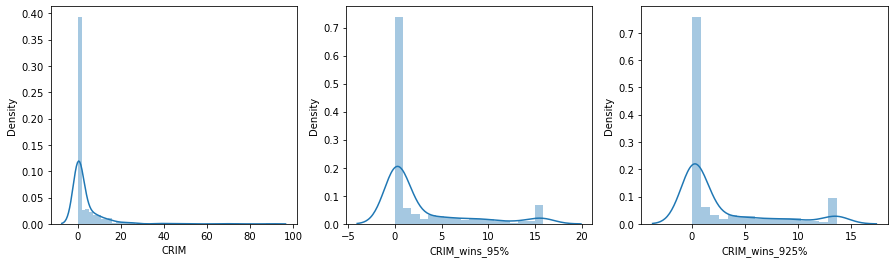

In [13]:
#Create copy of df
df_win = df.copy(deep=True)

#Winsorize on right-tail
df_win['CRIM_wins_95%'] = winsorize(df['CRIM'], limits=(0, 0.05))
df_win['CRIM_wins_925%'] = winsorize(df['CRIM'], limits=(0, 0.075))

print(df_win[['CRIM', 'CRIM_wins_95%', 'CRIM_wins_925%']].describe())

#Distribution plot: Crime rate per capita by town
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.distplot(df['CRIM'])

#New distribution plots 
plt.subplot(1,3,2)
sns.distplot(df_win['CRIM_wins_95%'])
plt.subplot(1,3,3)
sns.distplot(df_win['CRIM_wins_925%'])

With winsorizing, the mean crime rate per capita changed from 3.61 to 2.80 (95%).

#### For univariate outliers:
- Winsorize to keep as much data as possible
- To find the right winsorization level, know your data! A percentage point close to the outer fence is considered best practice
- Zero limits can be meaningful if a variable can not have a value below zero
- Report main statistics (e.g., mean, std) before and after winsorizing

#### For multivariate outliers:
- For multivariate outliers, winsorizing is done on the ellipsoid (holding information from more than one variable)
- There doesn’t seem to be an existing python package that deals with winsorization on ellipsoids. Yet, there exists a function called mvTopCoding as part of an R package [sdcMicro](https://www.rdocumentation.org/packages/sdcMicro/versions/5.5.0) that winsorizes outliers on the ellipsoid defined by the (robust) Mahalanobis distance.

### Imputation
Imputation is a method that is often used when handling missing data. However, it is also applied when dealing with extreme values. When using imputation, outliers are removed (and with that become missing values) and are replaced with <b>estimates</b> based on the remaining data.

There are several imputation techniques. One that is often used, yet comes with a strong <i>bias</i>, is the simple mean substitution. Here, all outlier or missing values are substituted by the variables’ mean. A better alternative and more robust imputation method is the <b>multiple imputation</b>. 

In multiple imputation, missing values or outliers are replaced by <b>M</b> plausible estimates retrieved from a prediction model. The outlier becomes the dependent variable of a prediction model (e.g., regression, random forest etc.), and is estimated based on the remaining information non-missing/non-outlier values in an observation.

<img src="https://miro.medium.com/max/700/1*OywpRVqMAgcDkf3WSbqtCQ.png" width="500" height="100">

Choosing the right number of plausible estimates <b>M</b> for a missing value or outlier is frequently discussed in literature and it is often [recommended](https://stefvanbuuren.name/fimd/sec-howmany.html):
- Using m = 5−20 will be enough under moderate missingness

<b>For more details on various imputation techniques refer to my Notebook [here](https://nbviewer.jupyter.org/github/guptadeepak18/Templates/blob/main/Treating%20Missing%20Values.ipynb)</b>

Let us transform the outliers into missing values. For this, we will use the list of probable outliers detected by the Tukey Method

In [14]:
#Tukey's method

def tukeys_method(df, variable):  # Creating a User defined function
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss
        

probable_outliers_tm, possible_outliers_tm = tukeys_method(df, "CRIM")

print("Number of Probable Outliers:", len(probable_outliers_tm))
print("Number of Possible Outliers:", len(possible_outliers_tm))

print("\nProbable Outliers Index:", probable_outliers_tm)
print("\nPossible Outliers Index:", possible_outliers_tm)

Number of Probable Outliers: 30
Number of Possible Outliers: 66

Probable Outliers Index: [374, 375, 376, 378, 379, 380, 381, 384, 385, 386, 387, 398, 400, 403, 404, 405, 406, 410, 412, 413, 414, 415, 417, 418, 425, 427, 437, 440, 468, 477]

Possible Outliers Index: [367, 371, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 384, 385, 386, 387, 388, 392, 394, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 422, 425, 426, 427, 429, 431, 434, 435, 436, 437, 438, 439, 440, 441, 443, 444, 445, 447, 448, 454, 468, 469, 477, 478, 479]


In [15]:
# Probable outliers detected trough Tukey method

df_imp = df.copy(deep=True)

#Turn outliers into missing values for imputation
def outliers_to_nan(df, variable_name, probable_outliers):
    for i in probable_outliers_tm:
        df.at[i, variable_name] = None
    return df

df_imp = outliers_to_nan(df_imp, 'CRIM', probable_outliers_tm)                    

#df_imp[374:378] #to test NaN values       

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
374,NaN,0.0,18.1,0.0,0.668,4.138,100.0,1.1370,24.0,666.0,20.2,396.90,37.97
375,NaN,0.0,18.1,0.0,0.671,7.313,97.9,1.3163,24.0,666.0,20.2,396.90,13.44
376,NaN,0.0,18.1,0.0,0.671,6.649,93.3,1.3449,24.0,666.0,20.2,363.02,23.24
377,9.82349,0.0,18.1,0.0,0.671,6.794,98.8,1.3580,24.0,666.0,20.2,396.90,21.24


As an estimator, let us chose regularized linear regression (BayesianRidge), and for simplicity, we will set m=1 (single imputation). As already mentioned and also written in sklearns [user-guide](https://scikit-learn.org/stable/modules/impute.html#iterative-imputer), the imputer can be used for multiple imputations

count    506.000000
mean       2.366051
std        3.695306
min        0.006320
25%        0.082045
50%        0.256510
75%        3.677083
max       14.438300
Name: CRIM, dtype: float64


<AxesSubplot:xlabel='CRIM', ylabel='Density'>

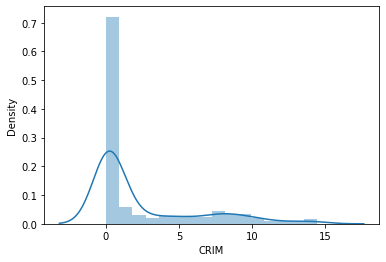

In [17]:
#Define imputer
imputer = IterativeImputer(estimator=BayesianRidge(),
                           n_nearest_features=None,
                           imputation_order='ascending')
                           #, sample_posterior=True)

    #Fit imputer and transform                          
imputer.fit(df_imp)
df_imp_tf = imputer.transform(df_imp)
df_imp = pd.DataFrame(df_imp_tf, columns = columns)

#New mean lowers to 2.36 with random seed at 10
print(df_imp['CRIM'].describe())

#New distribution plot
sns.distplot(df_imp['CRIM'])

Again, the mean crime rate per capita changed from 3.61 to 2.36

#### For univariate outliers:
- Next to treating missing data, often used technique for recoding outliers
- Multiple imputation more robust, single (e.g., mean) imputation is biased
- For imputation, R offers more mature and flexible packages than python.

#### For multivariate outliers:
- Imputation does not really make sense for multivariate outliers as they are defined as outlying observations across multiple variables (for a multiple outlier all entries would turn into a missing value leaving little space for prediction)

The treatment of outlying data points is a highly subjective task as there is no mathematical right or wrong solution. Qualitative information, such as knowing the source of an outlier or an outlier’s influence, can simplify treatment decisions. Error outliers are best to be corrected or deleted, while non-error outliers can be <b>kept, deleted, or recoded</b>. Several recoding methods exist for extreme values, with <b>winsorizing</b> and <b>multiple imputations</b> being among the popular ones.

An essential task is to report the outcome with and without outliers and supplying sound reasoning and explanation when treating outliers.